In [7]:
data_dir = "/Users/atishdhamala/Eye Disease Detection using Deep Learning/data/aptos"

In [1]:
pip install pandas torch torchvision matplotlib scikit-learn --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.metrics import confusion_matrix

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


## Data Augumentation with CLAHE

In [4]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, binary=False, apply_clahe=False):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.binary = binary
        self.apply_clahe = apply_clahe
        
        if self.binary:
            self.df['class'] = self.df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
        else:
            self.df['class'] = self.df['diagnosis']
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        filename = f"{record['id_code']}.png" 
        img_path = os.path.join(self.img_dir, filename)

        # CLAHE
        if self.apply_clahe:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(img)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl = clahe.apply(l)
            img_lab = cv2.merge((cl, a, b))
            img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            image = Image.fromarray(img_rgb)
        else:
            image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(record['class'])
        return image, label


In [5]:
# For training (with augmentation)
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# For validation and testing (no augmentation)
val_test_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [8]:
train_csv = os.path.join(data_dir, "train_split.csv")
val_csv   = os.path.join(data_dir, "val_split.csv")
test_csv  = os.path.join(data_dir, "test.csv")

train_img_dir = os.path.join(data_dir, "train_images")
test_img_dir  = os.path.join(data_dir, "test_images")

In [9]:
train_dataset = APTOSDataset(train_csv, train_img_dir, transform=train_transform, binary=False, apply_clahe=True)
val_dataset   = APTOSDataset(val_csv, train_img_dir, transform=val_test_transform, binary=False, apply_clahe=True)


In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [10]:
# Minimal transform for visualization (no normalization)
visual_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor()
])

# Load a small CLAHE-applied dataset
sample_dataset = APTOSDataset(csv_file=train_csv, img_dir=train_img_dir, 
                              transform=visual_transform, binary=False, apply_clahe=True)

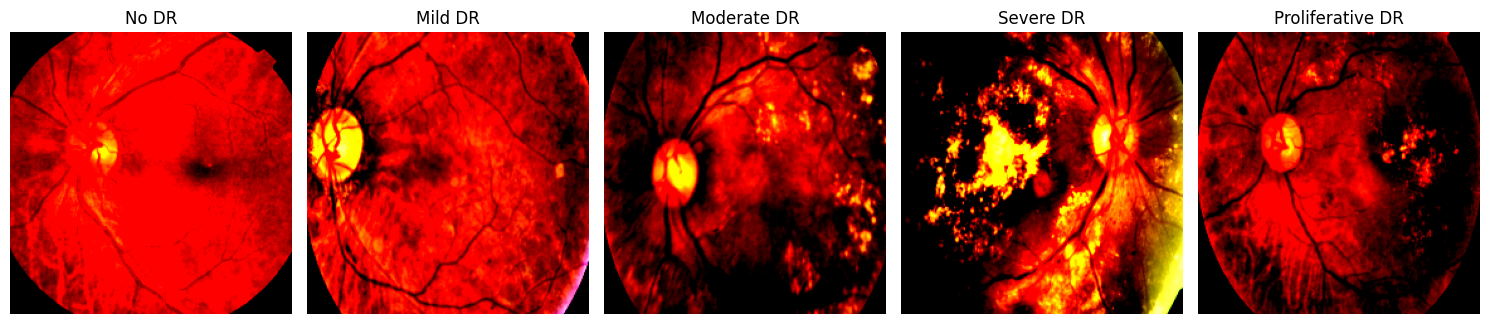

In [11]:
# 1. Setup your label map
label_map = {
    0: "No DR",
    1: "Mild DR",
    2: "Moderate DR",
    3: "Severe DR",
    4: "Proliferative DR"
}

# 2. Use visual transform (no normalization) for natural display
visual_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# 3. Load dataset with CLAHE and visual transform
clahe_dataset = APTOSDataset(csv_file=train_csv, img_dir=train_img_dir,
                             transform=visual_transform, binary=False, apply_clahe=True)

# 4. Get one image for each class
sample_indices = {}
for label in range(5):
    indices = clahe_dataset.df[clahe_dataset.df['diagnosis'] == label].index.tolist()
    if indices:
        sample_indices[label] = indices[0]
    else:
        print(f"No sample found for label {label}")

sample_images = {}
for label, idx in sample_indices.items():
    image, lab = clahe_dataset[idx]
    sample_images[label] = image

# 5. De-normalized imshow (skip mean/std since not normalized)
def imshow(img, title=None):
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW → HWC
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# 6. Plot images
plt.figure(figsize=(15, 4))
for i, label in enumerate(range(5)):
    plt.subplot(1, 5, i + 1)
    imshow(sample_images[label], title=label_map[label])
plt.tight_layout()
plt.show()


## ResNet50: Trained for 5 epochs

In [21]:
# Load pretrained ResNet50.
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer for 5 output classes.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

# Move the model to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print("Model, loss function, and optimizer are set up.")

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model, loss function, and optimizer are set up.


/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/5] | Train Loss: 0.6930, Train Acc: 73.75% | Val Loss: 0.8170, Val Acc: 68.62%
Epoch [2/5] | Train Loss: 0.4626, Train Acc: 83.07% | Val Loss: 0.4757, Val Acc: 80.49%
Epoch [3/5] | Train Loss: 0.3984, Train Acc: 85.18% | Val Loss: 0.4755, Val Acc: 80.76%
Epoch [4/5] | Train Loss: 0.3320, Train Acc: 87.81% | Val Loss: 0.4984, Val Acc: 81.86%
Epoch [5/5] | Train Loss: 0.2814, Train Acc: 89.48% | Val Loss: 0.5555, Val Acc: 79.26%


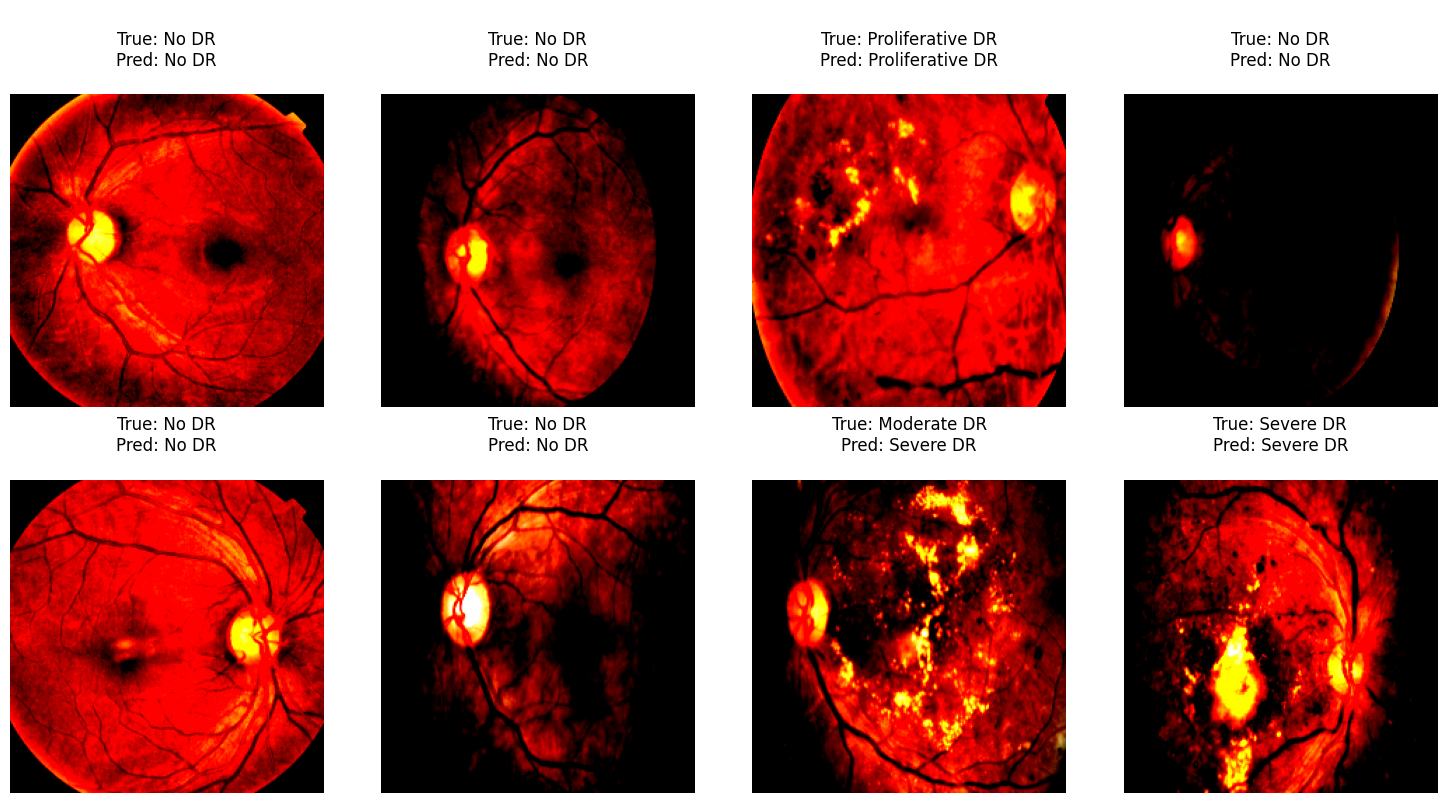

In [27]:
# Set the model to evaluation mode.
model.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"\nTrue: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}\n")
plt.tight_layout()
plt.show()

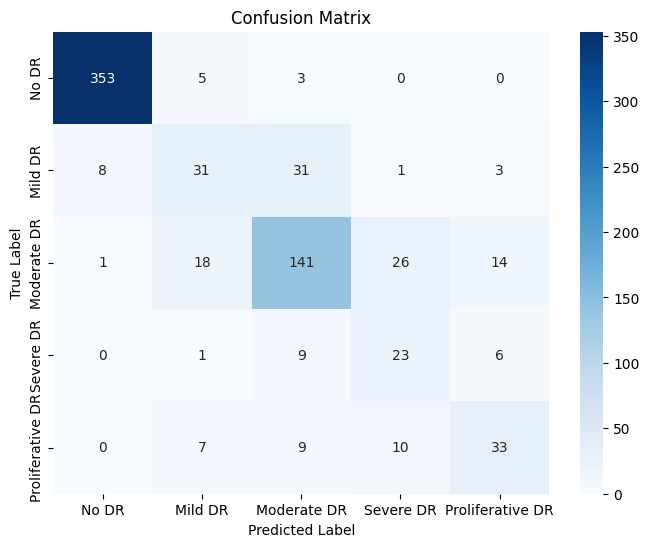

In [24]:
# Collect true labels and predictions for the entire validation set.
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

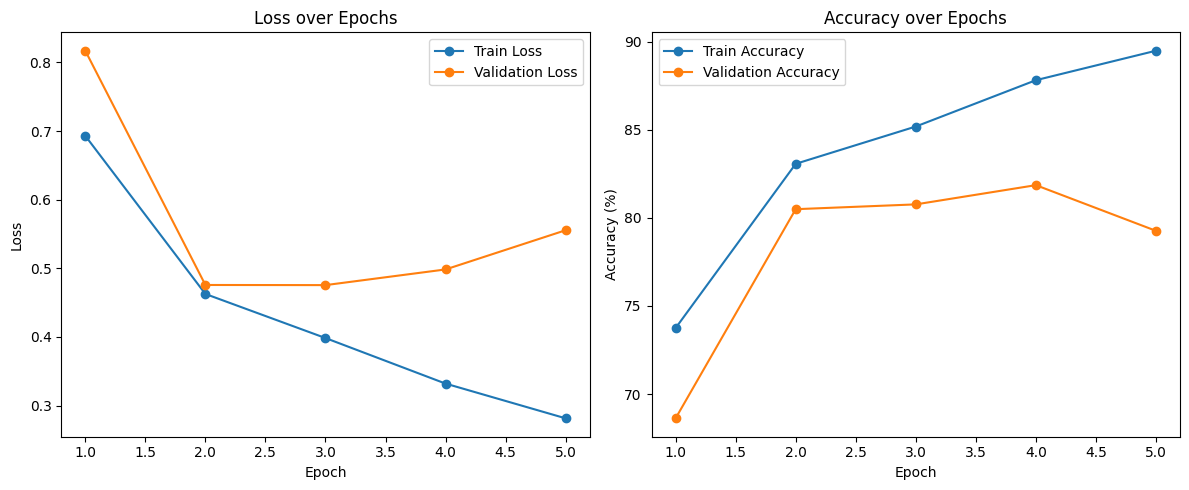

In [25]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## ResNet50 : Trained for 10 epochs

In [29]:
# Load pretrained ResNet50.
resnet50_10 = models.resnet50(pretrained=True)

# Replace the final fully connected layer for 5 output classes.
num_features = resnet50_10.fc.in_features
resnet50_10.fc = nn.Linear(num_features, 5)

# Move the model to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_10 = resnet50_10.to(device)

# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_10.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print("Model, loss function, and optimizer are set up.")

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model, loss function, and optimizer are set up.


/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [30]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    resnet50_10.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50_10(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    resnet50_10.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_10(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/10] | Train Loss: 0.6421, Train Acc: 75.96% | Val Loss: 0.5690, Val Acc: 79.26%
Epoch [2/10] | Train Loss: 0.4395, Train Acc: 83.54% | Val Loss: 0.5434, Val Acc: 79.95%
Epoch [3/10] | Train Loss: 0.3828, Train Acc: 85.46% | Val Loss: 0.5181, Val Acc: 79.67%
Epoch [4/10] | Train Loss: 0.3585, Train Acc: 87.13% | Val Loss: 0.5561, Val Acc: 81.04%
Epoch [5/10] | Train Loss: 0.2860, Train Acc: 89.21% | Val Loss: 0.6226, Val Acc: 77.49%
Epoch [6/10] | Train Loss: 0.2661, Train Acc: 89.89% | Val Loss: 0.6126, Val Acc: 80.49%
Epoch [7/10] | Train Loss: 0.1498, Train Acc: 94.71% | Val Loss: 0.5943, Val Acc: 83.49%
Epoch [8/10] | Train Loss: 0.1263, Train Acc: 95.77% | Val Loss: 0.6739, Val Acc: 82.67%
Epoch [9/10] | Train Loss: 0.1084, Train Acc: 96.21% | Val Loss: 0.6205, Val Acc: 83.49%
Epoch [10/10] | Train Loss: 0.0882, Train Acc: 97.41% | Val Loss: 0.6525, Val Acc: 82.13%


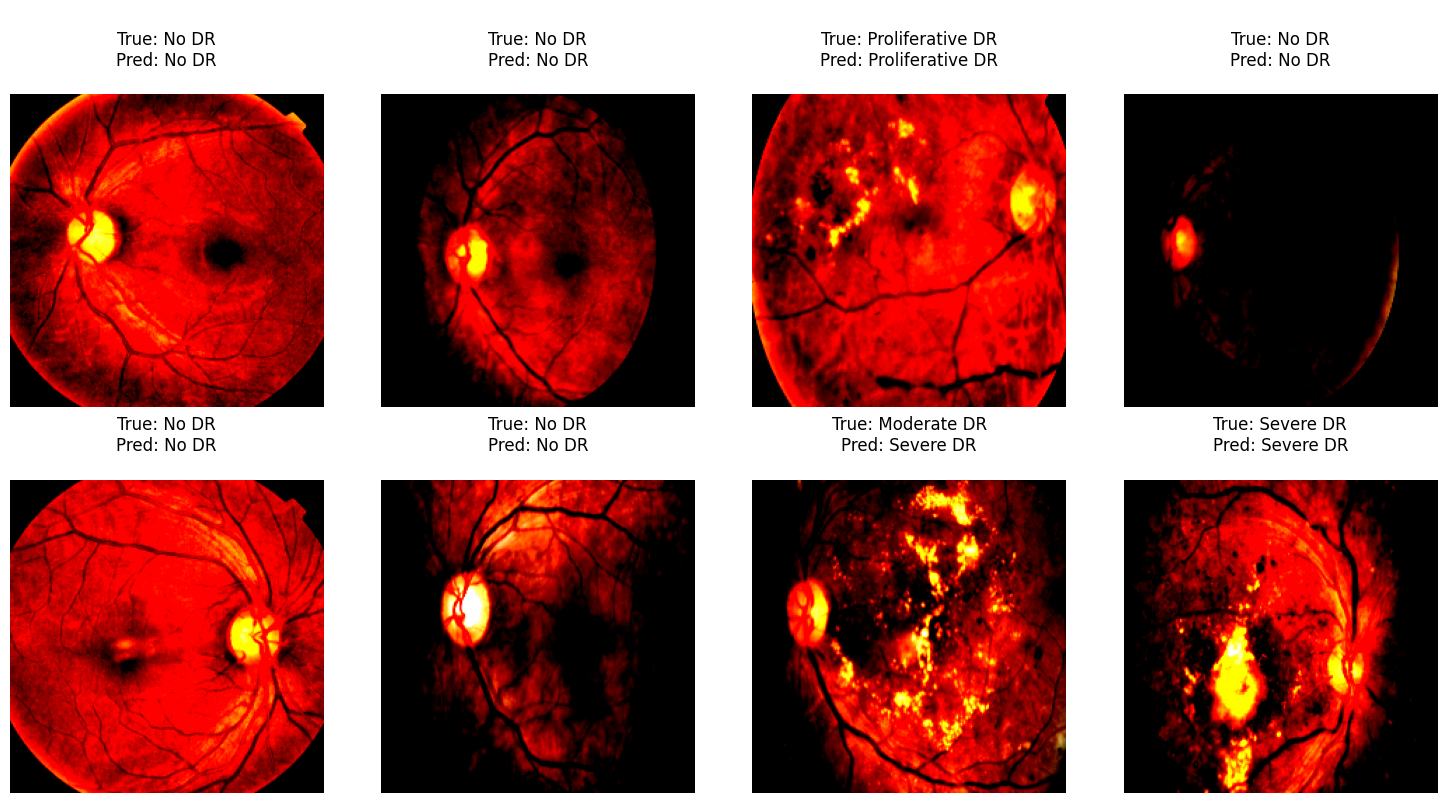

In [31]:
# Set the model to evaluation mode.
resnet50_10.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs =  resnet50_10(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"\nTrue: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}\n")
plt.tight_layout()
plt.show()

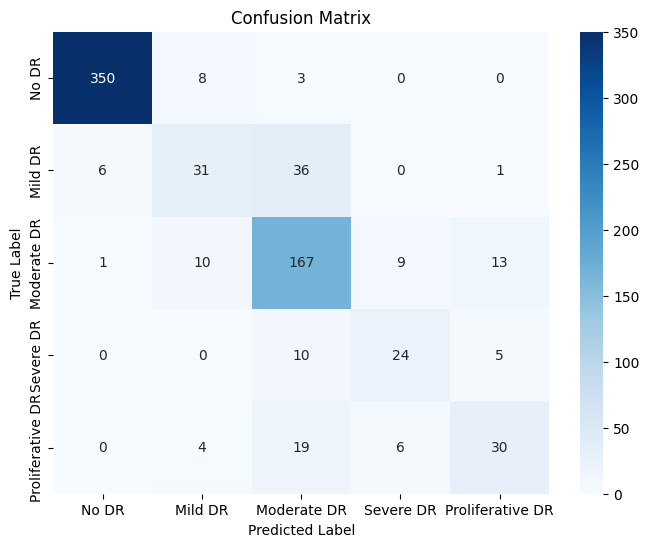

In [32]:
# Collect true labels and predictions for the entire validation set.
all_preds = []
all_true = []

resnet50_10.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs =  resnet50_10(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

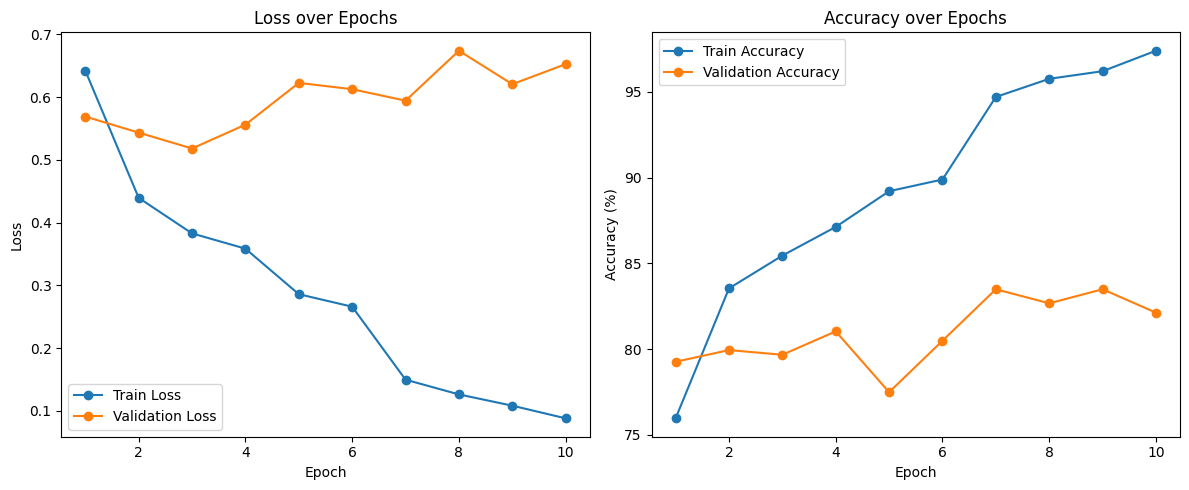

In [33]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## ResNet50: Final layer and fully connected layer

In [12]:
resnet_new = models.resnet50(pretrained=True)
num_features = resnet_new.fc.in_features
# Replace the final fully-connected layer with one that outputs 5 classes.
resnet_new.fc = nn.Linear(num_features, 5)

# Freeze all layers first.
for param in resnet_new.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the final block (layer4) and the final FC layer.
for param in resnet_new.layer4.parameters():
    param.requires_grad = True
for param in resnet_new.fc.parameters():
    param.requires_grad = True

# Move the model to the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_new = resnet_new.to(device)

# Set up the optimizer with differential learning rates.
optimizer = torch.optim.Adam([
    {"params": resnet_new.fc.parameters(), "lr": 1e-3},
    {"params": resnet_new.layer4.parameters(), "lr": 1e-4},
], weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Initialize lists to save metrics.
train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 5 

for epoch in range(num_epochs):
    resnet_new.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop for one epoch.
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet_new(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    epoch_loss = running_loss / total_train
    train_accuracy = (correct_train / total_train) * 100
    
    # Save training metrics.
    train_losses.append(epoch_loss)
    train_accs.append(train_accuracy)
    
    # Validation loop for one epoch.
    resnet_new.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet_new(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / total_val
    val_accuracy = (correct_val / total_val) * 100
    
    # Save validation metrics.
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    
    # Update the learning rate scheduler.
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracies:", train_accs)
print("Validation Accuracies:", val_accs)

Epoch [1/5] | Train Loss: 0.6912 | Train Acc: 73.88% | Val Loss: 0.5791 | Val Acc: 77.90%
Epoch [2/5] | Train Loss: 0.4973 | Train Acc: 81.29% | Val Loss: 0.5520 | Val Acc: 80.49%
Epoch [3/5] | Train Loss: 0.4017 | Train Acc: 84.47% | Val Loss: 0.6193 | Val Acc: 77.76%
Epoch [4/5] | Train Loss: 0.3791 | Train Acc: 86.14% | Val Loss: 0.6464 | Val Acc: 79.54%
Epoch [5/5] | Train Loss: 0.3080 | Train Acc: 88.15% | Val Loss: 0.6664 | Val Acc: 79.67%
Training Losses: [0.6912083929209385, 0.49730582463533735, 0.40174473976266795, 0.37914696819100946, 0.307996208684442]
Validation Losses: [0.5790636812681066, 0.5520329354241958, 0.6192718562130063, 0.6464419211241916, 0.6664315417388614]
Training Accuracies: [73.88187094571526, 81.2905428473882, 84.46568794810516, 86.13861386138613, 88.15295322635713]
Validation Accuracies: [77.89904502046384, 80.49113233287858, 77.76261937244202, 79.53615279672579, 79.67257844474761]


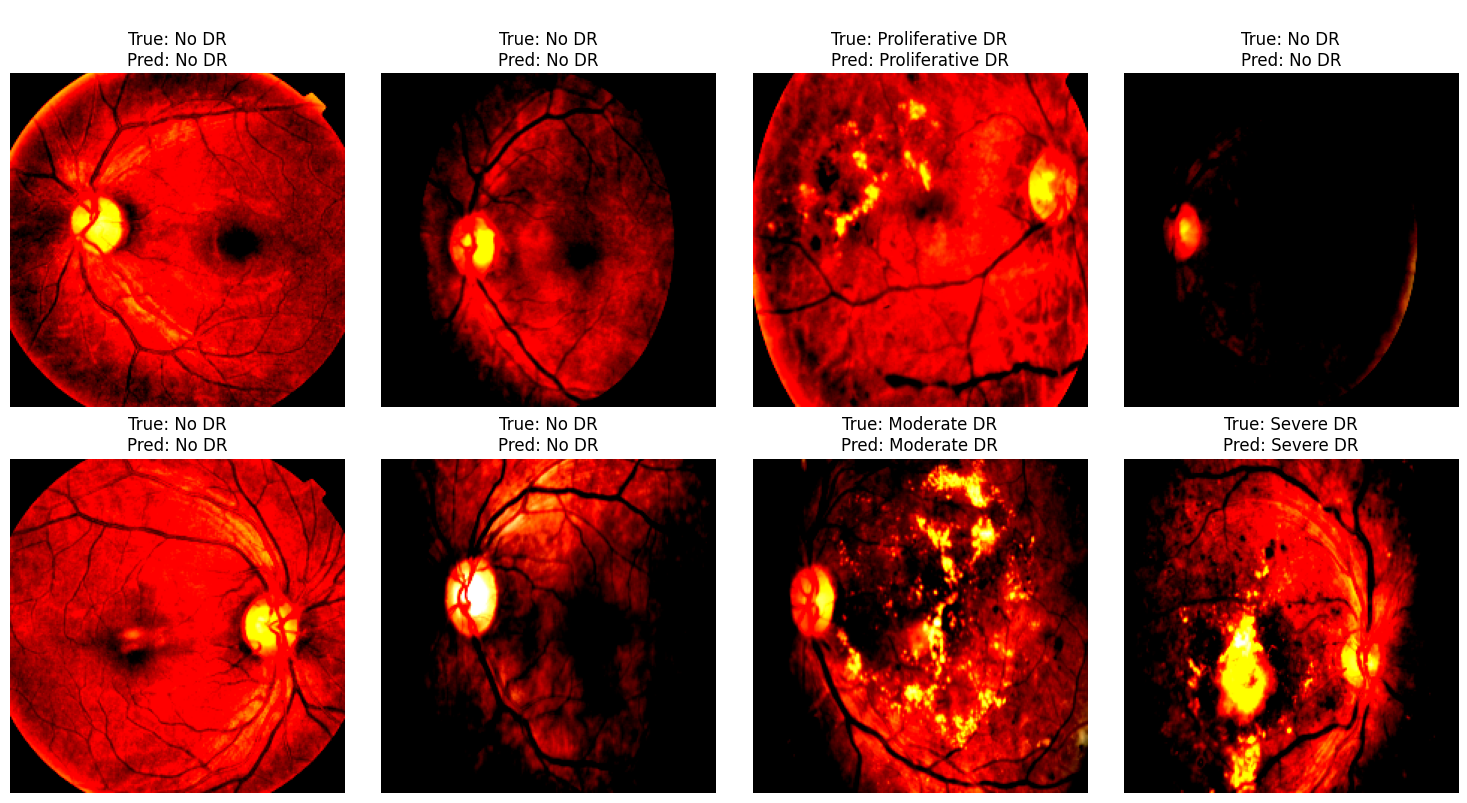

In [24]:
# Set the model to evaluation mode.
resnet_new.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = resnet_new(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"\nTrue: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

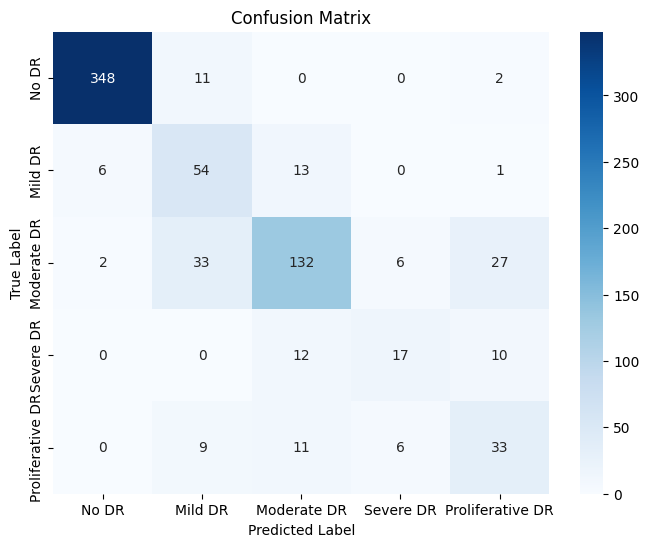

In [17]:
# Collect true labels and predictions for the entire validation set.
all_preds = []
all_true = []

resnet_new.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_new(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

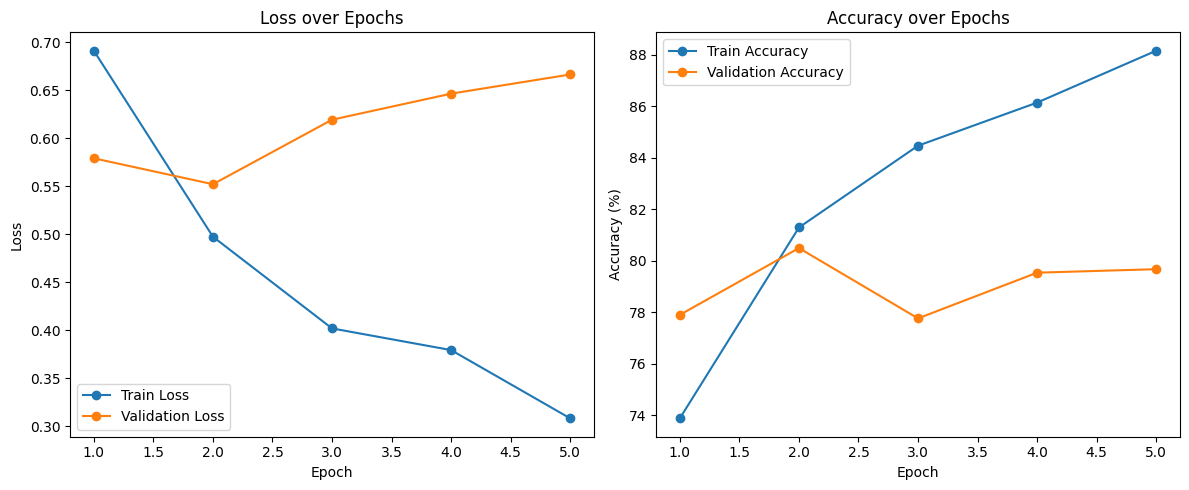

In [18]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Efficient Net - B0

In [19]:
# 1. Load EfficientNet-B0 pretrained on ImageNet.
efficientnet = models.efficientnet_b0(pretrained=True)

# 2. Replace the classifier to output 5 classes.
# EfficientNet-B0's classifier is typically a Sequential containing a Dropout and a Linear layer.
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, 5)

# 3. Freeze the base parameters.
# We'll freeze all parameters first, then unfreeze the classifier.
for param in efficientnet.parameters():
    param.requires_grad = False

# Unfreeze the classifier parameters so that they can be trained.
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

# 4. Move the model to the available device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

# 5. Set up the optimizer.
# We use a higher learning rate for the classifier and a lower one for any fine-tuned features.
optimizer = torch.optim.Adam([
    {"params": efficientnet.classifier.parameters(), "lr": 1e-3},
], weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# 6. Initialize lists to save metrics.
train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 10

# 7. Training Loop
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(epoch_loss)
    train_accs.append(train_accuracy)

    # Validation phase
    efficientnet.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracies:", train_accs)
print("Validation Accuracies:", val_accs)

Epoch [1/10] | Train Loss: 0.9693 | Train Acc: 65.65% | Val Loss: 0.7878 | Val Acc: 73.12%
Epoch [2/10] | Train Loss: 0.7487 | Train Acc: 73.57% | Val Loss: 0.7157 | Val Acc: 74.08%
Epoch [3/10] | Train Loss: 0.6713 | Train Acc: 75.45% | Val Loss: 0.6813 | Val Acc: 75.03%
Epoch [4/10] | Train Loss: 0.6563 | Train Acc: 76.10% | Val Loss: 0.6599 | Val Acc: 75.44%
Epoch [5/10] | Train Loss: 0.6309 | Train Acc: 76.51% | Val Loss: 0.6608 | Val Acc: 75.44%
Epoch [6/10] | Train Loss: 0.6133 | Train Acc: 76.48% | Val Loss: 0.6637 | Val Acc: 75.72%
Epoch [7/10] | Train Loss: 0.6139 | Train Acc: 77.02% | Val Loss: 0.6485 | Val Acc: 75.99%
Epoch [8/10] | Train Loss: 0.5882 | Train Acc: 77.71% | Val Loss: 0.6468 | Val Acc: 76.13%
Epoch [9/10] | Train Loss: 0.5931 | Train Acc: 78.18% | Val Loss: 0.6517 | Val Acc: 75.72%
Epoch [10/10] | Train Loss: 0.5868 | Train Acc: 77.94% | Val Loss: 0.6331 | Val Acc: 77.22%
Training Losses: [0.9692696137573175, 0.7486884215049835, 0.6712796883641676, 0.656343436

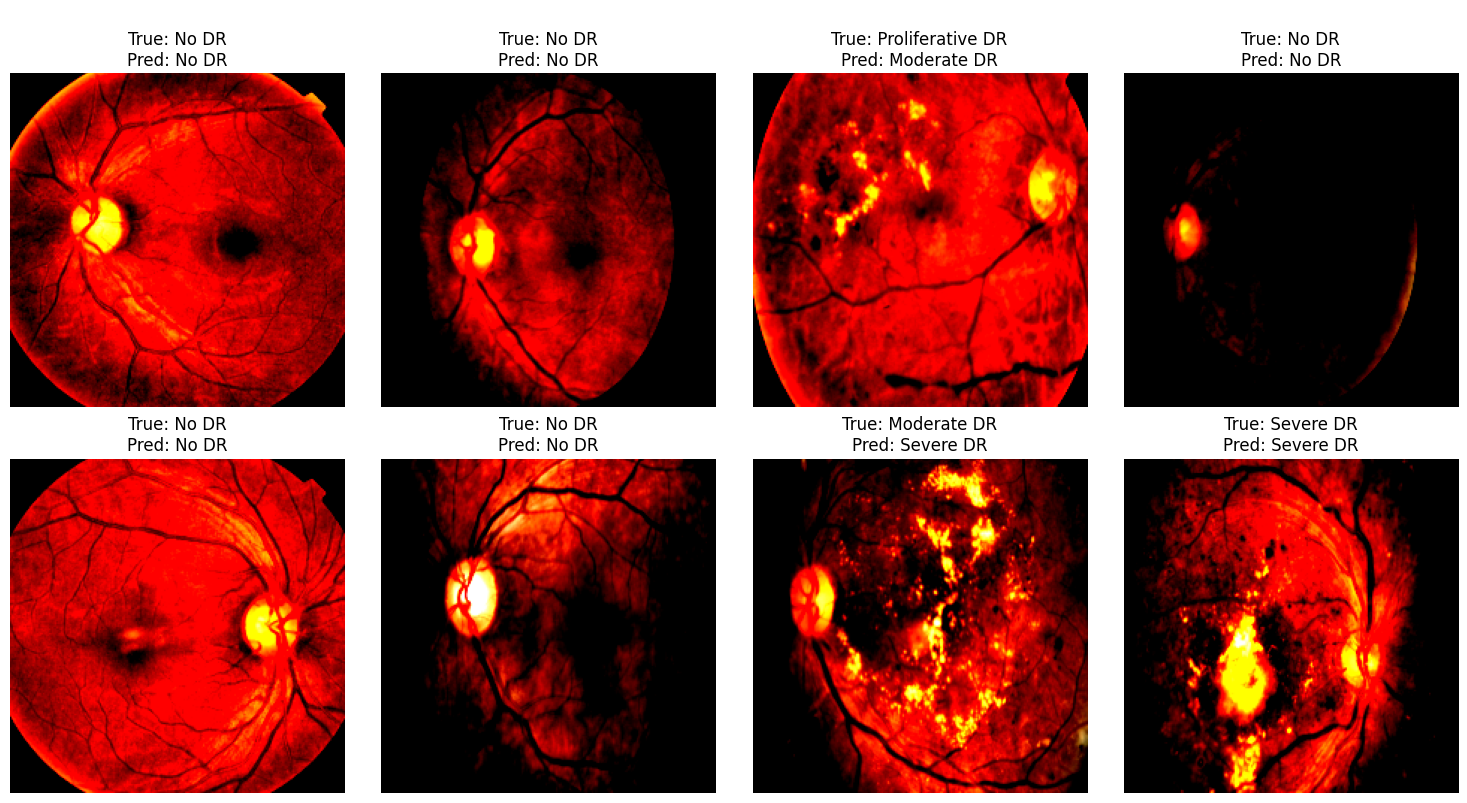

In [25]:
# Set the model to evaluation mode.
efficientnet.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = efficientnet(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"\nTrue: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

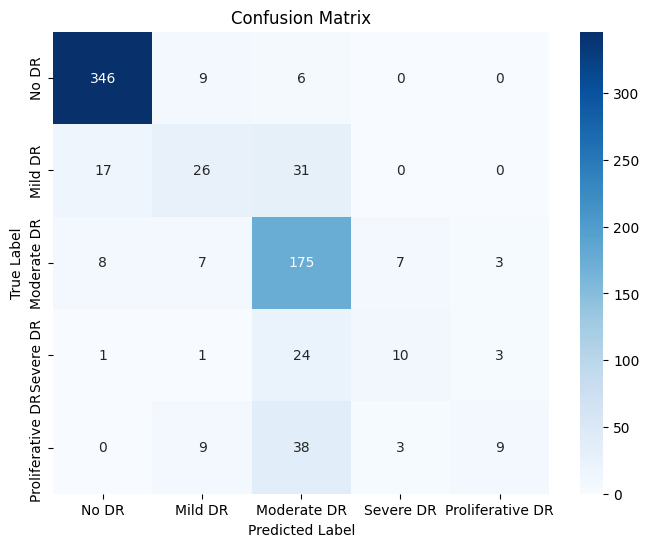

In [22]:
# Collect true labels and predictions for the entire validation set.
all_preds_eff = []
all_true_eff = []

efficientnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds_eff.extend(preds.cpu().numpy())
        all_true_eff.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm_eff = confusion_matrix(all_true_eff, all_preds_eff)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

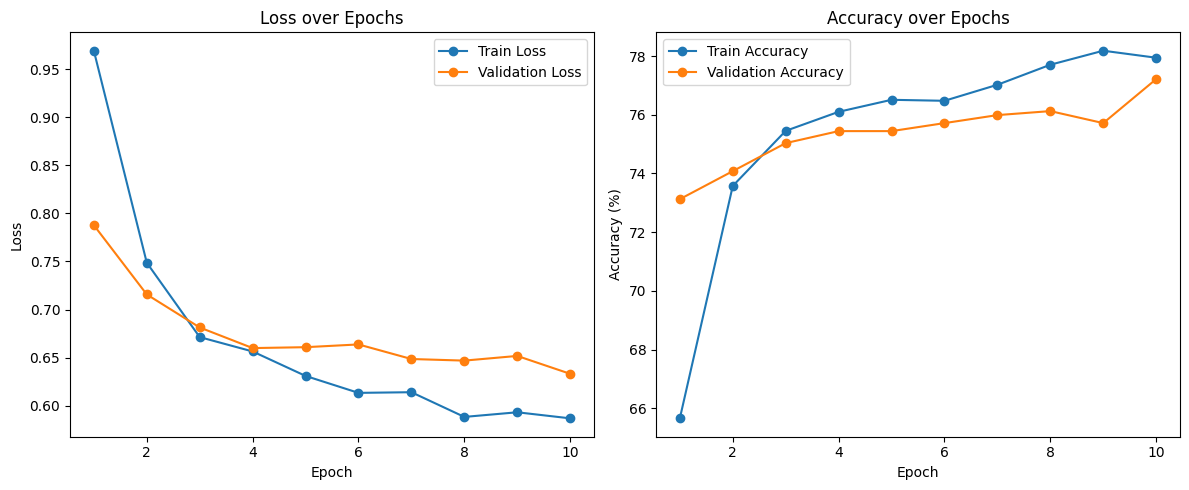

In [23]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()